# In this notebook I want to 
-create 256 X 256 data <br>
-create a UNET that works for this data <br>
-Train the model <br>
-Assess the results 

From what I did before Using 32X32 images, it seems that the network still tries to create signal out of noisy images. 

In [14]:
#Importing packages

## Importing important stuff
import random
import numpy as np
import pandas as pd
from PIL import Image 
import tifffile as tiff
             ###############
#plotting
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
            ####################


In [18]:
#machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
###
from keras import models
from keras import layers

#from __future__ import print_function
#import keras
from keras import backend as K
#import matplotlib
#from matplotlib import pyplot as plt
#import numpy as np
from keras.preprocessing.image import ImageDataGenerator
###
import pickle as pkl
import time

In [3]:
# reading the data 
df_good = pd.read_pickle("shuffled_good_df-Copy1.pkl")
df_bad=  pd.read_pickle("shuffled_bad_df-Copy1.pkl")
## making the pictures into numpy arrays, they are already shuffled so I can just split them as following. 
X = df_good.values #HSN images
y = df_bad.values  #LSN images


In [5]:
print(len(X))
print(len(y))

2300
2300


## Cropping

In [7]:

X_crop=[]
for sample in X:
    x_reshaped=sample.reshape(1200,1200)
    for i in range(1,4):
        for j in range(1,4):
            X_crop.append(x_reshaped[i*256:(i+1)*256, j*256:(j+1)*256])
            
y_crop=[]
for sample in y:
    y_reshaped=sample.reshape(1200,1200)
    for i in range(1,4):
        for j in range(1,4):
            y_crop.append(y_reshaped[i*256:(i+1)*256, j*256:(j+1)*256])

In [8]:
X_crop = np.asarray(X_crop)
y_crop  = np.asarray(y_crop)

In [9]:
print('shape of original bad images', X_crop.shape)
print('shape of original good images',y_crop.shape)

shape of original bad images (20700, 256, 256)
shape of original good images (20700, 256, 256)


In [10]:
#Saving them for future 
np.save('bd_orig_256.npy', X_crop, allow_pickle= True)
np.save('gd_orig_256.npy', y_crop, allow_pickle=True)

## Loading data

In [16]:
#loading the images 
X_crop = np.load('/users/PAS1495/akl2/work/Project/Notebooks/bd_orig_256.npy')
y_crop = np.load('/users/PAS1495/akl2/work/Project/Notebooks/gd_orig_256.npy')

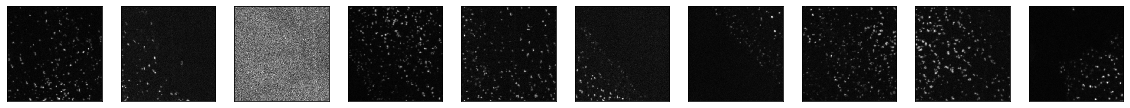

In [25]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_crop[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
   # ax = plt.subplot(2, n, i + 1 + n)
   # plt.imshow(y_crop[i].reshape(256, 256))
   # plt.gray()
   # ax.get_xaxis().set_visible(False)
   # ax.get_yaxis().set_visible(False)

plt.show()

## Image generation

In [19]:
#defning the image generator 

datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0, 
                             rotation_range=0, #rotating images by 90 degrees 
                             width_shift_range=0.0, 
                             height_shift_range=0.0, 
                             brightness_range=None, 
                             shear_range=0.0, 
                             zoom_range=0.0, 
                             channel_shift_range=0.0, 
                             fill_mode='nearest', 
                             cval=0.0, 
                             horizontal_flip=True, # flipping the image horizontally
                             vertical_flip=True,   #flipping the image vertically
                             rescale=None, 
                             preprocessing_function=None, 
                             data_format=None, validation_split=0.0, dtype=None)


In [21]:
#reshaping for image augmentation
X_tbaug  = X_crop.reshape(X_crop.shape[0], 256,256,1)
y_tbaug =  y_crop.reshape(y_crop.shape[0],256,256,1)

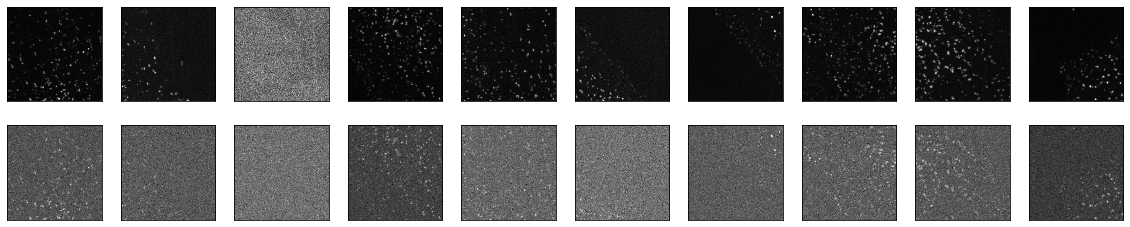

In [22]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_tbaug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_tbaug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
start= time.time()
batch_size=15000
x_aug=[]
i=0
for img_batch in datagen.flow(X_tbaug, batch_size=batch_size, seed=42):
    for img in img_batch:    
        im2=img.reshape(256,256)
        x_aug.append(im2)
        i=i+1    
    if i >= batch_size:
        break
        
x_aug = np.asarray(x_aug)


print('finished generating bad images')
print(' generated bad images shape', x_aug.shape)


y_aug=[]
i=0
for img_batch in datagen.flow(y_tbaug, batch_size=batch_size, seed=42):
    for img in img_batch:
        im2=img.reshape(256,256)
        y_aug.append(im2)
        i=i+1    
    if i >= batch_size:
        break
        
y_aug = np.asarray(y_aug)

print('finished generating good images')
print(' generated good images shape', y_aug.shape)

finished generating bad images
 generated bad images shape (15000, 256, 256)
finished generating good images
 generated good images shape (15000, 256, 256)


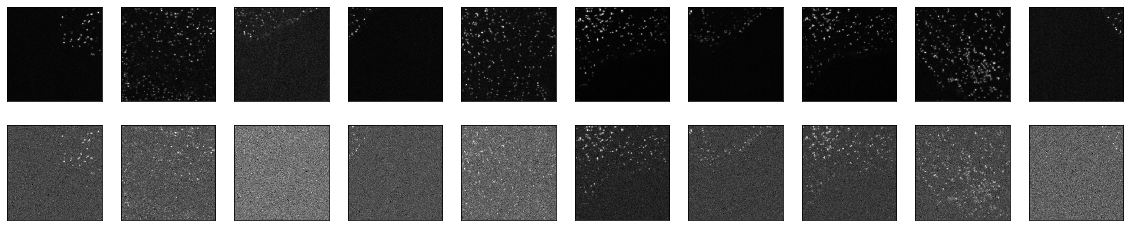

In [29]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_aug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_aug[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [33]:
x_aug == y_aug

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [36]:
#Saving generated images 
np.save('bd_aug_256_new.npy', y_aug)
np.save('gd_aug_256_new.npy', x_aug)

In [38]:
y=np.load('bd_aug_256_new.npy')
x=np.load('gd_aug_256_new.npy')

In [39]:
x==y

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

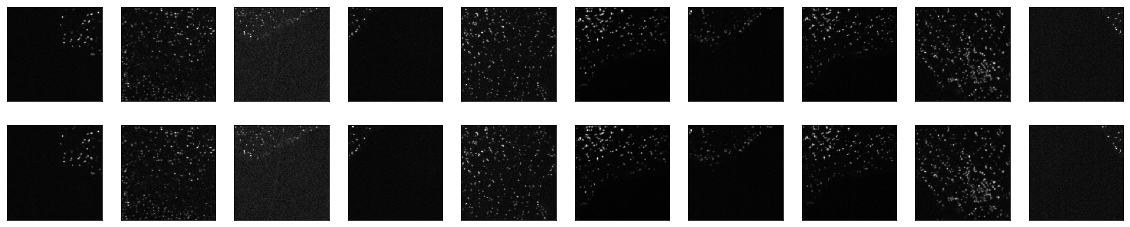

In [28]:
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
## Test train split
x_aug = x_aug.reshape(x_aug.shape[0],256,256)
y_aug = x_aug.reshape(y_aug.shape[0],256,256)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_aug, y_aug, test_size=0.2, random_state=42)

In [11]:
print('shape of X_train', X_train.shape)
print('shape of X_test', X_test.shape)
print('shape of y_train', y_train.shape)
print('shape of y_test', y_test.shape)

shape of X_train (12000, 256, 256)
shape of X_test (3000, 256, 256)
shape of y_train (12000, 256, 256)
shape of y_test (3000, 256, 256)


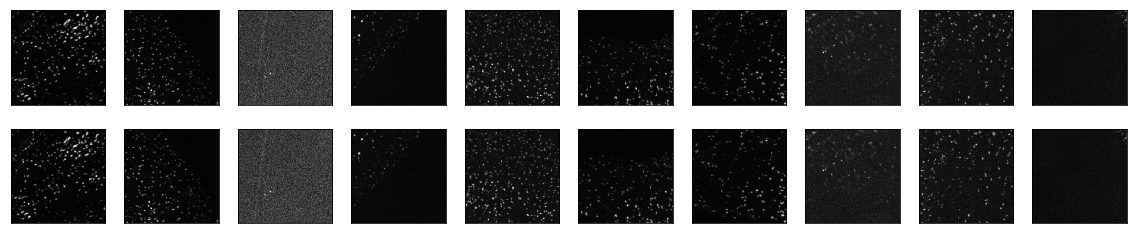

In [12]:
#Checking correspondance 
#checking correspondance 
#####check for correspondance
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
        # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_train[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()